# Ses Veriseti Analizi
Bu defter, özellik çıkarımı, kümeleme, görselleştirme ve basit bir sınıflandırma modeli oluşturma dahil olmak üzere ESC-50 ses veriseti analiz sürecini açıklamaktadır.

## 1. Gerekli Kütüphanelerin İçe Aktarılması

In [76]:
import pandas as pd
import numpy as np
import librosa
import requests
import os
import pickle
from IPython.display import display
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D  # 3D çizim için gerekliv
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import hdbscan
import warnings

## 2. Dosyaları İndirme Fonksiyonu

In [13]:
# ESC-50 veri kümesinin meta bilgilerini (CSV formatında) içeren dosyanın URL'si
CSV_URL = "https://raw.githubusercontent.com/karolpiczak/ESC-50/master/meta/esc50.csv"

# ESC-50 veri kümesindeki ses dosyalarının bulunduğu temel URL
AUDIO_BASE_URL = "https://github.com/karolpiczak/ESC-50/raw/master/audio/"

# İnternetten bir dosyayı indirip belirtilen isimle kaydeden fonksiyon
def download_file(url, filename):
    """Belirtilen URL'den dosyayı indirir ve verilen dosya adına kaydeder."""
    
    # İndirme işleminin başladığını ekrana yazdır
    print(f"'{filename}' indiriliyor...")
    
    try:
        # URL'ye GET isteği gönder, veriyi parça parça (stream) indir
        response = requests.get(url, stream=True)
        
        # HTTP hatası varsa (404, 500 vb.) hata fırlat
        response.raise_for_status()
        
        # Dosyayı ikili (binary) modda yazmak için aç
        with open(filename, 'wb') as f:
            # Veriyi 8192 baytlık parçalar halinde oku ve dosyaya yaz
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        
        # Başarılı indirme mesajı yazdır
        print(f"'{filename}' başarıyla indirildi.")
    
    except requests.exceptions.RequestException as e:
        # İndirme sırasında hata oluşursa ekrana yazdır
        print(f"Hata oluştu: '{filename}' indirilemedi. {e}")
        
        # Başarısız indirme için False döndür
        return False
    
    # Başarılı indirme için True döndür
    return True


## 3. CSV Dosyasını İndirme ve Verileri Yükleme

In [14]:
# İndirilecek veya okunacak CSV dosyasının yerel (local) adı
csv_filename = "esc50.csv"

# Eğer CSV dosyası mevcut değilse, URL'den indir
if not os.path.exists(csv_filename):
    download_file(CSV_URL, csv_filename)

# CSV dosyasını pandas DataFrame olarak oku
df = pd.read_csv(csv_filename)


'esc50.csv' indiriliyor...
'esc50.csv' başarıyla indirildi.


In [15]:
# İşlenecek maksimum ses dosyası sayısı
limit = 2000  

# DataFrame'deki 'filename' sütununu listeye çevir (ses dosyalarının adları)
audio_files = df['filename'].tolist()  

# "audio" klasörü yoksa oluştur
if not os.path.exists("audio"):
    os.makedirs("audio")


## 4. Ses Dosyalarını İndirme ve Özellik Çıkarma

In [16]:
# Özellikleri (features) saklamak için boş listeler oluştur
mfcc_features = []               # MFCC özellikleri
chroma_features = []             # Chroma özellikleri
spectral_contrast_features = []  # Spektral kontrast özellikleri
file_names = []                  # Dosya adları
labels = []                      # Sınıflandırma etiketleri

# İşlem başladığını ekrana yazdır
print("\nSes dosyaları işleniyor...")

# Tüm ses dosyaları üzerinde döngü
for audio_file in audio_files:
    # Ses dosyasının yerel yolunu oluştur
    audio_path = os.path.join("audio", audio_file)
    
    # Dosya yoksa URL'den indir
    if not os.path.exists(audio_path):
        download_file(AUDIO_BASE_URL + audio_file, audio_path)
    
    try:
        # Ses dosyasını yükle (y: ses verisi, sr: örnekleme oranı)
        y, sr = librosa.load(audio_path)
        
        # MFCC (Mel-Frekans Kepstrum Katsayıları) çıkar
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfccs_mean = np.mean(mfccs.T, axis=0)  # Zaman boyutu üzerinde ortalama
        mfcc_features.append(mfccs_mean)       # Listeye ekle
        
        # Chroma özelliklerini çıkar
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        chroma_mean = np.mean(chroma.T, axis=0)
        chroma_features.append(chroma_mean)
        
        # Spektral kontrast özelliklerini çıkar
        spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        spectral_contrast_mean = np.mean(spectral_contrast.T, axis=0)
        spectral_contrast_features.append(spectral_contrast_mean)
        
        # Dosya adını ve kategorisini ekle
        file_names.append(audio_file)
        labels.append(df[df['filename'] == audio_file]['category'].iloc[0])
        
        # Başarılı çıkarım mesajı yazdır
        print(f"'{audio_file}' için MFCC, Chroma ve Spectral Contrast çıkarıldı.")
    
    except Exception as e:
        # Hata durumunda mesaj yazdır
        print(f"Hata oluştu: '{audio_file}' işlenemedi. {e}")



Ses dosyaları işleniyor...
'audio\1-100032-A-0.wav' indiriliyor...
'audio\1-100032-A-0.wav' başarıyla indirildi.
'1-100032-A-0.wav' için MFCC, Chroma ve Spectral Contrast çıkarıldı.
'audio\1-100038-A-14.wav' indiriliyor...
'audio\1-100038-A-14.wav' başarıyla indirildi.
'1-100038-A-14.wav' için MFCC, Chroma ve Spectral Contrast çıkarıldı.
'audio\1-100210-A-36.wav' indiriliyor...
'audio\1-100210-A-36.wav' başarıyla indirildi.
'1-100210-A-36.wav' için MFCC, Chroma ve Spectral Contrast çıkarıldı.
'audio\1-100210-B-36.wav' indiriliyor...
'audio\1-100210-B-36.wav' başarıyla indirildi.
'1-100210-B-36.wav' için MFCC, Chroma ve Spectral Contrast çıkarıldı.
'audio\1-101296-A-19.wav' indiriliyor...
'audio\1-101296-A-19.wav' başarıyla indirildi.
'1-101296-A-19.wav' için MFCC, Chroma ve Spectral Contrast çıkarıldı.
'audio\1-101296-B-19.wav' indiriliyor...
'audio\1-101296-B-19.wav' başarıyla indirildi.
'1-101296-B-19.wav' için MFCC, Chroma ve Spectral Contrast çıkarıldı.
'audio\1-101336-A-30.wav' i

C:\Users\somef\AppData\Local\Temp\ipykernel_1776\2076890326.py:15: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_path)
D:\Users\somef\anaconda3\Lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


'audio\1-16746-A-15.wav' başarıyla indirildi.
'1-16746-A-15.wav' için MFCC, Chroma ve Spectral Contrast çıkarıldı.
'audio\1-17092-A-27.wav' indiriliyor...
'audio\1-17092-A-27.wav' başarıyla indirildi.
'1-17092-A-27.wav' için MFCC, Chroma ve Spectral Contrast çıkarıldı.
'audio\1-17092-B-27.wav' indiriliyor...
'audio\1-17092-B-27.wav' başarıyla indirildi.
'1-17092-B-27.wav' için MFCC, Chroma ve Spectral Contrast çıkarıldı.
'audio\1-17124-A-43.wav' indiriliyor...
'audio\1-17124-A-43.wav' başarıyla indirildi.
'1-17124-A-43.wav' için MFCC, Chroma ve Spectral Contrast çıkarıldı.
'audio\1-17150-A-12.wav' indiriliyor...
'audio\1-17150-A-12.wav' başarıyla indirildi.
'1-17150-A-12.wav' için MFCC, Chroma ve Spectral Contrast çıkarıldı.
'audio\1-172649-A-40.wav' indiriliyor...
'audio\1-172649-A-40.wav' başarıyla indirildi.
'1-172649-A-40.wav' için MFCC, Chroma ve Spectral Contrast çıkarıldı.
'audio\1-172649-B-40.wav' indiriliyor...
'audio\1-172649-B-40.wav' başarıyla indirildi.
'1-172649-B-40.wav'

D:\Users\somef\anaconda3\Lib\site-packages\librosa\core\pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


'audio\1-21934-A-38.wav' başarıyla indirildi.
'1-21934-A-38.wav' için MFCC, Chroma ve Spectral Contrast çıkarıldı.
'audio\1-21935-A-38.wav' indiriliyor...
'audio\1-21935-A-38.wav' başarıyla indirildi.
'1-21935-A-38.wav' için MFCC, Chroma ve Spectral Contrast çıkarıldı.
'audio\1-223162-A-25.wav' indiriliyor...
'audio\1-223162-A-25.wav' başarıyla indirildi.
'1-223162-A-25.wav' için MFCC, Chroma ve Spectral Contrast çıkarıldı.
'audio\1-22694-A-20.wav' indiriliyor...
'audio\1-22694-A-20.wav' başarıyla indirildi.
'1-22694-A-20.wav' için MFCC, Chroma ve Spectral Contrast çıkarıldı.
'audio\1-22694-B-20.wav' indiriliyor...
'audio\1-22694-B-20.wav' başarıyla indirildi.
'1-22694-B-20.wav' için MFCC, Chroma ve Spectral Contrast çıkarıldı.
'audio\1-22804-A-46.wav' indiriliyor...
'audio\1-22804-A-46.wav' başarıyla indirildi.
'1-22804-A-46.wav' için MFCC, Chroma ve Spectral Contrast çıkarıldı.
'audio\1-22882-A-44.wav' indiriliyor...
'audio\1-22882-A-44.wav' başarıyla indirildi.
'1-22882-A-44.wav' iç

In [17]:
# MFCC özellik listesini NumPy dizisine çevir
X_mfcc = np.array(mfcc_features)

# Chroma özellik listesini NumPy dizisine çevir
X_chroma = np.array(chroma_features)

# Spektral kontrast özellik listesini NumPy dizisine çevir
X_spectral_contrast = np.array(spectral_contrast_features)

# Tüm özellikleri yatay olarak birleştir (tek bir özellik matrisi X oluştur)
X = np.hstack((X_mfcc, X_chroma, X_spectral_contrast))

# Etiketleri (kategori isimleri) sayısal değerlere dönüştürmek için LabelEncoder kullan
le = LabelEncoder()

# Etiketleri (y) sayısal değerlere dönüştür
y = le.fit_transform(labels)


In [46]:
# Hücre 2: Özellik sütun isimlerini oluştur

# 13 adet MFCC sütun ismi oluştur: MFCC_1, MFCC_2, ... MFCC_13
feature_columns = [f'MFCC_{i+1}' for i in range(13)] + \
                  
                  # 12 adet Chroma sütun ismi oluştur: Chroma_1, ... Chroma_12
                  [f'Chroma_{i+1}' for i in range(12)] + \
                  
                  # 7 adet Spektral Kontrast sütun ismi oluştur: SpectralContrast_1, ... SpectralContrast_7
                  [f'SpectralContrast_{i+1}' for i in range(7)]


In [47]:
# Hücre 3: Özelliklerle birlikte DataFrame oluştur

# Özellik matrisinden (X) ve sütun isimlerinden (feature_columns) bir DataFrame oluştur
df_features = pd.DataFrame(X, columns=feature_columns)

# Ses dosyalarının adlarını DataFrame'e ekle
df_features['dosya_adi'] = file_names

# Kategorilerin (etiketlerin) orijinal metin hallerini ekle
df_features['kategori'] = labels

# Kategorilerin sayısal kodlanmış hallerini ekle
df_features['kategori_kodlu'] = y


In [48]:
print("="*80)
# Başlık: Veri hakkında genel bilgiler
print("📊 Veri Hakkında Genel Bilgiler")
# Tekrar "=" çizgisi
print("="*80)
# DataFrame'deki toplam ses dosyası sayısını yazdır
print(f"Ses dosyası sayısı: {len(df_features)}")
# Toplam özellik (feature) sayısını yazdır
print(f"Özellik sayısı: {len(feature_columns)}")
# Toplam sınıf (kategori) sayısını yazdır
print(f"Sınıf sayısı: {len(np.unique(y))}")

📊 Veri Hakkında Genel Bilgiler
Ses dosyası sayısı: 1990
Özellik sayısı: 32
Sınıf sayısı: 50


In [49]:

print("="*80)
# Başlık: Mevcut kategoriler
print("📂 Mevcut Kategoriler")
# Tekrar "=" çizgisi
print("="*80)
# 'kategori' sütunundaki her kategorinin kaç kez geçtiğini say ve yazdır
print(df_features['kategori'].value_counts())

📂 Mevcut Kategoriler
kategori
11    107
31     85
1      82
43     78
0      77
2      72
19     71
12     71
40     66
49     65
7      63
8      62
27     62
39     56
5      53
47     52
25     51
6      50
30     46
10     45
37     44
23     42
13     41
17     41
14     40
36     37
20     37
18     37
16     36
34     35
44     33
41     29
22     24
15     22
24     21
29     16
28     16
26     16
9      16
42     16
3      15
48     14
21     11
4      11
32     10
35      9
46      3
38      2
33      1
45      1
Name: count, dtype: int64


In [50]:
# Görsel ayrım için 80 karakter uzunluğunda "=" işareti yazdır
print("="*80)
# Başlık: İlk 10 dosya
print("🔍 İlk 10 Dosya")
# Tekrar "=" çizgisi
print("="*80)
# Eğer display() fonksiyonu mevcutsa (ör. Jupyter Notebook ortamında), DataFrame'i daha güzel göster
if display:
    display(df_features[['dosya_adi', 'kategori', 'MFCC_1', 'Chroma_1', 'SpectralContrast_1']].head(10))
else:
    # Eğer display() yoksa, verileri normal print ile yazdır
    print(df_features[['dosya_adi', 'kategori', 'MFCC_1', 'Chroma_1', 'SpectralContrast_1']].head(10))

🔍 İlk 10 Dosya


,dosya_adi,kategori,MFCC_1,Chroma_1,SpectralContrast_1
0,1-100032-A-0.wav,47,-600.940186,0.042679,14.326380
1,1-100038-A-14.wav,24,-193.978195,0.196118,19.399698
2,1-100210-A-36.wav,29,16.259266,0.159135,15.198257
3,1-100210-B-36.wav,29,17.771097,0.143590,14.297561
4,1-101296-A-19.wav,16,-423.075226,0.592749,19.576451
5,1-101296-B-19.wav,16,-399.657562,0.547045,19.737973
6,1-101336-A-30.wav,0,-434.757202,0.369623,14.735009
7,1-101404-A-34.wav,31,-488.842316,0.729320,16.006386
8,1-103298-A-9.wav,43,-118.723053,0.545701,12.756604
9,1-103995-A-30.wav,12,-568.592163,0.158304,13.444657


In [51]:
# Görsel ayrım için 80 karakter uzunluğunda "=" işareti yazdır
print("="*80)
# Başlık: Özellik istatistikleri
print("📈 Özellik İstatistikleri")
# Tekrar "=" çizgisi
print("="*80)
# Eğer display() fonksiyonu varsa (ör. Jupyter Notebook'ta), istatistikleri tablo şeklinde göster
if display:
    display(df_features[feature_columns].describe().round(3))
else:
    # display() yoksa, istatistikleri konsola yazdır
    print(df_features[feature_columns].describe().round(3))

📈 Özellik İstatistikleri


,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,MFCC_10,...,Chroma_10,Chroma_11,Chroma_12,SpectralContrast_1,SpectralContrast_2,SpectralContrast_3,SpectralContrast_4,SpectralContrast_5,SpectralContrast_6,SpectralContrast_7
count,1990.000,1990.000,1990.000,1990.000,1990.000,1990.000,1990.000,1990.000,1990.000,1990.000,...,1990.000,1990.000,1990.000,1990.000,1990.000,1990.000,1990.000,1990.000,1990.000,1990.000
mean,-295.313,76.096,-13.268,10.542,-2.314,5.273,-1.879,3.426,-1.253,2.593,...,0.436,0.434,0.444,16.851,12.767,15.181,15.816,17.230,17.465,43.829
std,172.910,55.727,32.141,19.675,16.026,12.944,12.081,10.726,9.692,8.359,...,0.201,0.200,0.205,3.821,2.712,3.362,3.505,3.780,3.911,8.110
min,-823.460,-152.223,-166.993,-62.389,-88.316,-48.047,-83.483,-48.351,-43.266,-33.741,...,0.000,0.001,0.000,5.603,4.633,5.213,5.652,7.192,7.208,12.103
25%,-418.709,36.469,-31.118,0.312,-10.928,-1.999,-8.425,-2.283,-6.533,-2.059,...,0.280,0.280,0.292,13.990,10.962,12.937,13.637,14.841,15.042,43.728
50%,-286.498,72.709,-9.832,10.304,-1.314,4.769,-1.083,3.032,-0.824,2.526,...,0.448,0.449,0.457,16.353,12.045,14.229,14.846,16.266,16.383,45.642
75%,-165.787,111.101,5.237,22.500,7.153,13.240,4.889,8.951,4.025,7.334,...,0.593,0.591,0.604,19.109,13.768,16.516,16.882,18.765,19.053,47.937
max,117.617,284.340,98.824,116.087,109.281,69.392,45.512,60.966,49.112,47.169,...,0.999,1.000,1.000,37.513,30.781,32.726,39.783,47.537,40.914,72.321


## 5. Kümeleme Algoritmalarının Uygulanması (K-Means, DBSCAN, GMM)

🔧 Veriyi iyileştiriliyor...
✅ Veriye StandardScaler uygulandı
✅ PCA: 32 → 21 boyut (95.5% varyans açıklanıyor)

🔍 K-Means ile en uygun küme sayısı aranıyor...
K=10: Silhouette Skoru = 0.117
K=20: Silhouette Skoru = 0.079
K=30: Silhouette Skoru = 0.075
K=40: Silhouette Skoru = 0.080
K=50: Silhouette Skoru = 0.066
✅ En iyi küme sayısı: K=10 (Skor: 0.117)

🎯 GMM uygulanıyor (K=10)...
GMM Silhouette Skoru: 0.028

🔧 HDBSCAN parametreleri iyileştiriliyor...
Yapılandırma {'min_cluster_size': 10, 'min_samples': 5}: 2 küme, 1594 gürültü - Reddedildi (küme az veya gürültü fazla)
Yapılandırma {'min_cluster_size': 15, 'min_samples': 10}: 2 küme, 1574 gürültü - Skor: 0.580
Yapılandırma {'min_cluster_size': 20, 'min_samples': 15}: 2 küme, 1631 gürültü - Reddedildi (küme az veya gürültü fazla)
Yapılandırma {'min_cluster_size': 25, 'min_samples': 20}: 2 küme, 1610 gürültü - Reddedildi (küme az veya gürültü fazla)
✅ En iyi HDBSCAN: {'min_cluster_size': 15, 'min_samples': 10}, Skor: 0.580

📊 Grafikler o

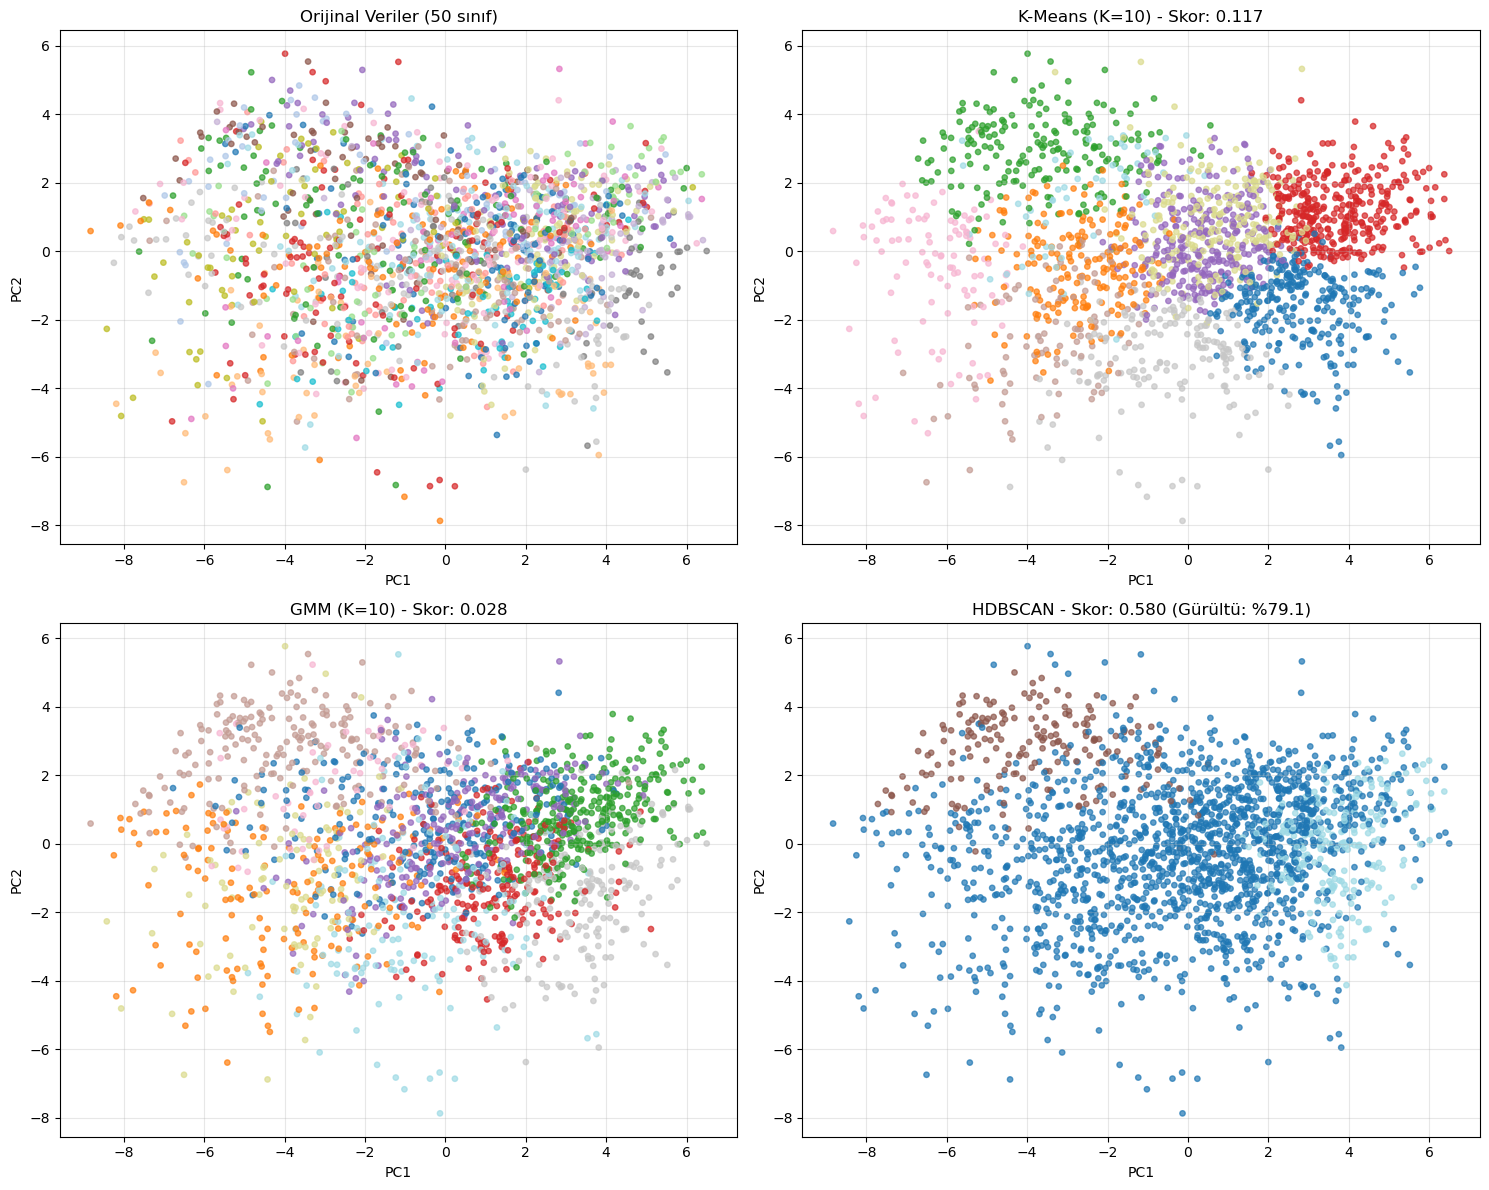


🏆 Nihai Rapor - Kümeleme Sonuçları
K-Means (K=10): 0.117
GMM (K=10): 0.028
HDBSCAN: 0.580

 En iyi yöntem: HDBSCAN (Skor: 0.580)


In [54]:
# FutureWarning uyarılarını gizle
warnings.filterwarnings("ignore", category=FutureWarning)

# Verilerin (X) mevcut olup olmadığını kontrol et
if 'X' not in locals():
    print("❌ Lütfen önce veri işleme kodunu çalıştırın!")
else:
    print("🔧 Veriler iyileştiriliyor...")

    # 1️⃣ StandardScaler ile özellikleri standartlaştır (ortalama=0, std=1)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    print("✅ StandardScaler uygulandı")
    
    # 2️⃣ PCA ile boyut azaltma (%95 varyansı koruyacak şekilde)
    pca = PCA(n_components=0.95, random_state=0)
    X_pca = pca.fit_transform(X_scaled)
    print(f"✅ PCA: {X.shape[1]} boyuttan {X_pca.shape[1]} boyuta düşürüldü ({pca.explained_variance_ratio_.sum():.1%} varyans)")

    # 3️⃣ K-Means ile farklı küme sayılarında deneme yap ve Silhouette Score ile en iyisini bul
    print("\n🔍 K-Means için en iyi küme sayısını arıyor...")
    K_range = [10, 20, 30, 40, 50]  # Denenecek küme sayıları
    silhouette_scores = []

    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
        labels = kmeans.fit_predict(X_pca)
        score = silhouette_score(X_pca, labels)
        silhouette_scores.append(score)
        print(f"K={k}: Silhouette Score = {score:.3f}")

    # En iyi K değerini bul
    best_k = K_range[np.argmax(silhouette_scores)]
    best_score = max(silhouette_scores)
    print(f"✅ En iyi küme sayısı: K={best_k} (Skor: {best_score:.3f})")

    # 4️⃣ Gaussian Mixture Model (GMM) ile aynı K değeriyle deneme
    print(f"\n🎯 GMM uygulanıyor (K={best_k})...")
    gmm = GaussianMixture(n_components=best_k, random_state=0, max_iter=300)
    clusters_gmm = gmm.fit_predict(X_pca)

    # Skor hesaplama
    if len(np.unique(clusters_gmm)) > 1:
        score_gmm = silhouette_score(X_pca, clusters_gmm)
        print(f"GMM Silhouette Score: {score_gmm:.3f}")
    else:
        score_gmm = None
        print("GMM: Birden fazla küme bulunamadı")

    # 5️⃣ HDBSCAN için farklı parametreler dene
    print("\n🔧 HDBSCAN parametreleri deneniyor...")
    hdbscan_configs = [
        {"min_cluster_size": 10, "min_samples": 5},
        {"min_cluster_size": 15, "min_samples": 10},
        {"min_cluster_size": 20, "min_samples": 15},
        {"min_cluster_size": 25, "min_samples": 20}
    ]

    best_hdbscan_score = -1
    best_hdbscan_clusters = None
    best_hdbscan_config = None

    for config in hdbscan_configs:
        clusterer = hdbscan.HDBSCAN(**config)
        clusters = clusterer.fit_predict(X_pca)

        noise_count = np.sum(clusters == -1)  # Gürültü olarak etiketlenen nokta sayısı
        unique_clusters = len(np.unique(clusters[clusters != -1]))  # Gerçek küme sayısı

        print(f"Ayar {config}: {unique_clusters} küme, {noise_count} gürültü", end="")

        if unique_clusters > 1 and noise_count < len(clusters) * 0.8:
            mask = clusters != -1
            if np.sum(mask) > 10:
                score = silhouette_score(X_pca[mask], clusters[mask])
                print(f" - Skor: {score:.3f}")

                if score > best_hdbscan_score:
                    best_hdbscan_score = score
                    best_hdbscan_clusters = clusters
                    best_hdbscan_config = config
            else:
                print(" - Çok az veri kaldı")
        else:
            print(" - Reddedildi (küme sayısı az veya gürültü oranı yüksek)")

    # En iyi HDBSCAN sonucunu kaydet
    if best_hdbscan_clusters is not None:
        print(f"✅ En iyi HDBSCAN ayarı: {best_hdbscan_config}, Skor: {best_hdbscan_score:.3f}")
        clusters_hdbscan = best_hdbscan_clusters
        score_hdbscan = best_hdbscan_score
    else:
        print("❌ HDBSCAN iyi sonuç vermedi")
        clusters_hdbscan = None
        score_hdbscan = None

    # 6️⃣ Görselleştirme
    print("\n📊 Grafikler oluşturuluyor...")
    pca_2d = PCA(n_components=2, random_state=0)
    X_pca_2d = pca_2d.fit_transform(X_scaled)

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Orijinal veriler (etiketler varsa)
    if 'y' in locals():
        axes[0,0].scatter(X_pca_2d[:,0], X_pca_2d[:,1], c=y, cmap='tab20', s=15, alpha=0.7)
        axes[0,0].set_title(f'Orijinal Veri ({len(np.unique(y))} sınıf)')
    else:
        axes[0,0].text(0.5, 0.5, 'Etiket yok', ha='center', va='center', fontsize=14)
        axes[0,0].set_title('Orijinal Veri')

    # K-Means
    kmeans_best = KMeans(n_clusters=best_k, random_state=0, n_init=10)
    kmeans_clusters = kmeans_best.fit_predict(X_pca)
    axes[0,1].scatter(X_pca_2d[:,0], X_pca_2d[:,1], c=kmeans_clusters, cmap='tab20', s=15, alpha=0.7)
    axes[0,1].set_title(f'K-Means (K={best_k}) - Skor: {best_score:.3f}')

    # GMM
    if clusters_gmm is not None and score_gmm is not None:
        axes[1,0].scatter(X_pca_2d[:,0], X_pca_2d[:,1], c=clusters_gmm, cmap='tab20', s=15, alpha=0.7)
        axes[1,0].set_title(f'GMM (K={best_k}) - Skor: {score_gmm:.3f}')
    else:
        axes[1,0].text(0.5, 0.5, 'GMM başarısız', ha='center', va='center', fontsize=14)
        axes[1,0].set_title('GMM - Başarısız')

    # HDBSCAN
    if clusters_hdbscan is not None and score_hdbscan is not None:
        noise_pct = np.sum(clusters_hdbscan == -1) / len(clusters_hdbscan) * 100
        axes[1,1].scatter(X_pca_2d[:,0], X_pca_2d[:,1], c=clusters_hdbscan, cmap='tab20', s=15, alpha=0.7)
        axes[1,1].set_title(f'HDBSCAN - Skor: {score_hdbscan:.3f} (Gürültü: %{noise_pct:.1f})')
    else:
        axes[1,1].text(0.5, 0.5, 'HDBSCAN başarısız', ha='center', va='center', fontsize=14)
        axes[1,1].set_title('HDBSCAN - Başarısız')

    plt.tight_layout()
    plt.show()

    # 7️⃣ Sonuç raporu
    print("\n" + "="*70)
    print("🏆 Nihai Rapor - Kümeleme Sonuçları")
    print("="*70)
    print(f"K-Means (K={best_k}): {best_score:.3f}")
    if score_gmm is not None:
        print(f"GMM (K={best_k}): {score_gmm:.3f}")
    if score_hdbscan is not None:
        print(f"HDBSCAN: {score_hdbscan:.3f}")

    # En iyi yöntemi belirle
    methods = {f'K-Means (K={best_k})': best_score}
    if score_gmm is not None:
        methods[f'GMM (K={best_k})'] = score_gmm
    if score_hdbscan is not None:
        methods['HDBSCAN'] = score_hdbscan


## 6. Sonuçların PCA ve t-SNE ile görselleştirilmesi

HDBSCAN algoritması 4 küme buldu .


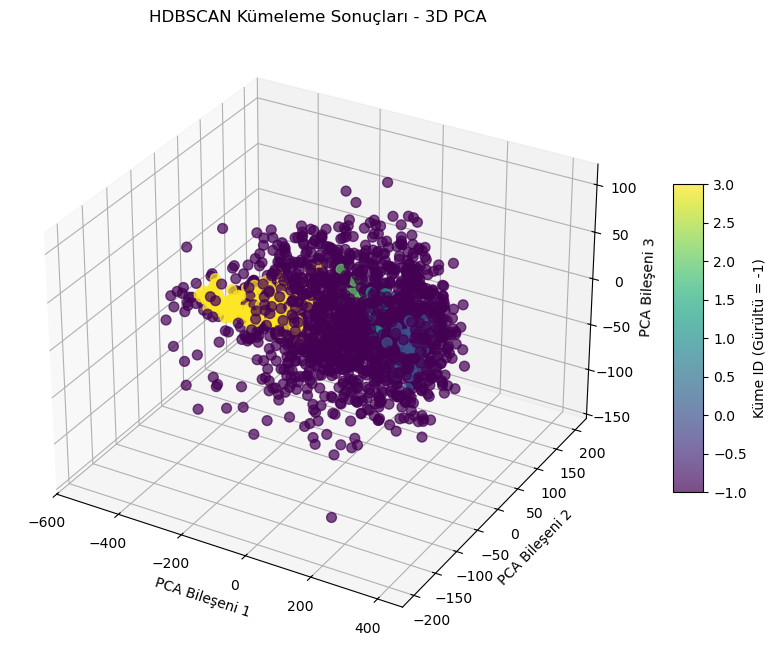

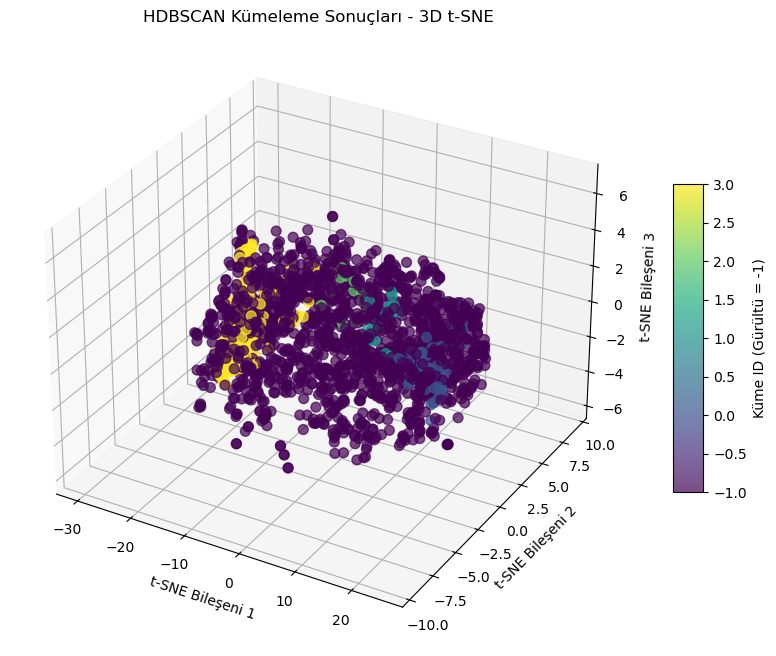

In [77]:
# --- Adım 1: HDBSCAN ile kümeleme ---
# HDBSCAN algoritmasını belirli parametrelerle başlatıyoruz:
# min_cluster_size = 15 → bir kümenin minimum örnek sayısı
# min_samples = 10 → bir noktanın çekirdek nokta olabilmesi için gerekli minimum komşu sayısı
clusterer = hdbscan.HDBSCAN(min_cluster_size=15, min_samples=10)
clusters_hdbscan = clusterer.fit_predict(X)  # Kümeleme işlemi

# Gürültü = -1 olarak etiketlenir, bu yüzden toplam küme sayısından 1 çıkarıyoruz
print(f"HDBSCAN algoritması {len(np.unique(clusters_hdbscan)) - 1} küme buldu.")

# --- Adım 2: PCA ile 3D Görselleştirme ---
# PCA (Principal Component Analysis) ile veriyi 3 boyuta indiriyoruz
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

# 3D grafik oluşturma
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# PCA sonucu elde edilen 3 bileşeni kullanarak noktaları çiziyoruz
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
                     c=clusters_hdbscan, cmap='viridis', s=50, alpha=0.7)

ax.set_title('HDBSCAN Kümeleme Sonuçları - 3D PCA')
ax.set_xlabel('PCA Bileşeni 1')
ax.set_ylabel('PCA Bileşeni 2')
ax.set_zlabel('PCA Bileşeni 3')

# Renk skalası ekleme (küme ID'leri için)
cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('Küme ID (Gürültü = -1)')

plt.show()

# --- Adım 3: t-SNE ile 3D Görselleştirme ---
# t-SNE (t-Distributed Stochastic Neighbor Embedding) ile 3 boyutlu görselleştirme
# Bu yöntem özellikle karmaşık veri setlerinde daha net ayrımlar gösterebilir
tsne = TSNE(n_components=3, random_state=0)
X_tsne = tsne.fit_transform(X)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2],
                     c=clusters_hdbscan, cmap='viridis', s=50, alpha=0.7)

ax.set_title('HDBSCAN Kümeleme Sonuçları - 3D t-SNE')
ax.set_xlabel('t-SNE Bileşeni 1')
ax.set_ylabel('t-SNE Bileşeni 2')
ax.set_zlabel('t-SNE Bileşeni 3')

# Renk skalası ekleme
cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('Küme ID (Gürültü = -1)')

plt.show()

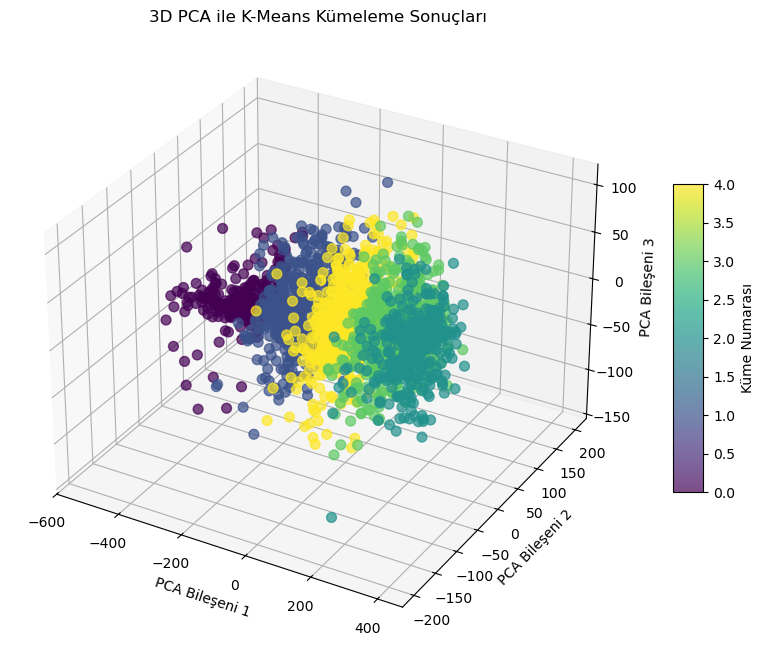

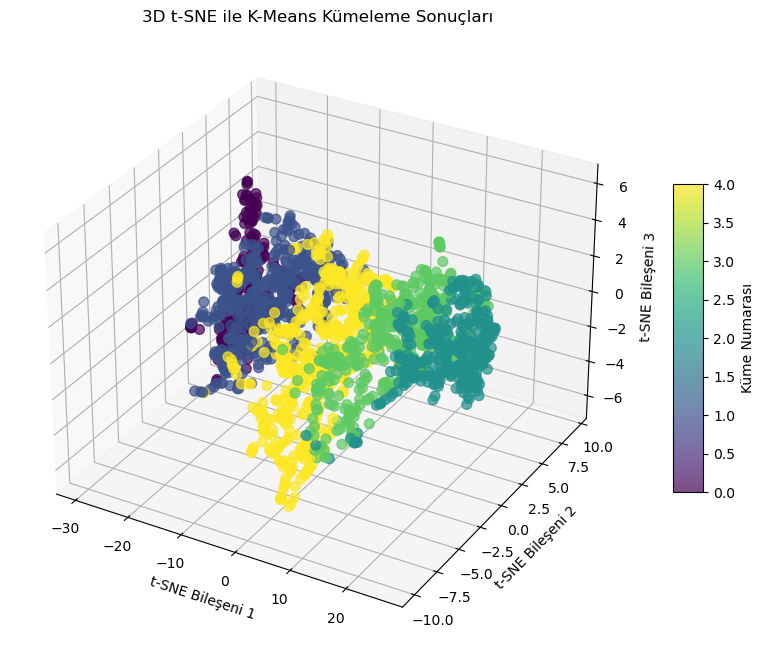

In [78]:
# --- 1. K-Means Kümeleme ---
n_clusters = 5  # Belirlemek istediğiniz küme sayısı
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
clusters_kmeans = kmeans.fit_predict(X)  # K-Means ile kümeleri bulma

# Veri ile etiketlerin uyumlu olduğunu kontrol et
assert len(clusters_kmeans) == len(X), "Hata: Küme etiketleri ile veri uzunluğu uyuşmuyor!"

# === 2. PCA ile 3D Boyut İndirgeme ve Görselleştirme ===
# PCA (Principal Component Analysis) ile 3 boyuta indiriyoruz
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# PCA sonucu noktaları kümelere göre renklendirerek çiziyoruz
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
                     c=clusters_kmeans, cmap='viridis', s=50, alpha=0.7)

ax.set_title('3D PCA ile K-Means Kümeleme Sonuçları')
ax.set_xlabel('PCA Bileşeni 1')
ax.set_ylabel('PCA Bileşeni 2')
ax.set_zlabel('PCA Bileşeni 3')

# Renk skalası ekleme (küme numaralarını gösterir)
cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('Küme Numarası')

plt.show()

# === 3. t-SNE ile 3D Boyut İndirgeme ve Görselleştirme ===
# t-SNE (t-Distributed Stochastic Neighbor Embedding) ile 3 boyutlu indirgeme
# Perplexity değeri, veri boyutuna uygun şekilde ayarlanır
perplexity_value = min(30, len(X) - 1)
tsne = TSNE(n_components=3, random_state=0, perplexity=perplexity_value)

# Önce PCA ile indirgenmiş veriyi t-SNE'ye veriyoruz (daha hızlı ve kararlı olur)
X_tsne = tsne.fit_transform(X_pca)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# t-SNE sonucu noktaları kümelere göre renklendirerek çiziyoruz
scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2],
                     c=clusters_kmeans, cmap='viridis', s=50, alpha=0.7)

ax.set_title('3D t-SNE ile K-Means Kümeleme Sonuçları')
ax.set_xlabel('t-SNE Bileşeni 1')
ax.set_ylabel('t-SNE Bileşeni 2')
ax.set_zlabel('t-SNE Bileşeni 3')

# Renk skalası ekleme
cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('Küme Numarası')

plt.show()

## 8. Sonüçları Kaydet

In [81]:
import os
import json

# Ses dosyalarının bulunduğu klasör yolu (burayı kendi klasörüne göre değiştir)
klasor_yolu = "C:/Users/somef/Downloads/audio"

# Klasördeki .wav dosyalarını bul ve listeye ekle
dosya_isimleri = [f for f in os.listdir(klasor_yolu) if f.endswith(".wav")]

print(f"{len(dosya_isimleri)} adet ses dosyası bulundu.")

# Küme etiketlerini (örneğin clusters_hdbscan) burada kullan
kume_etiketleri = clusters_hdbscan  # Veya istediğin kümeleme sonucu

# Dosya sayısı ile küme sayısı eşleşiyor mu kontrol et
assert len(dosya_isimleri) == len(kume_etiketleri), "Dosya sayısı ile küme sayısı uyuşmuyor!"

# Dosya adı ve küme etiketlerini eşleştir
dosya_kume_map = {dosya_isimleri[i]: int(kume_etiketleri[i]) for i in range(len(dosya_isimleri))}

# Sonuçları JSON dosyasına kaydet
with open("kume_ses_dosyalar.json", "w", encoding="utf-8") as f:
    json.dump(dosya_kume_map, f, indent=4, ensure_ascii=False)

print("✅ Kümeleme sonuçları 'kume_ses_dosyalar.json' dosyasına başarıyla kaydedildi.")


1990 adet ses dosyası bulundu.
✅ Kümeleme sonuçları 'kume_ses_dosyalar.json' dosyasına başarıyla kaydedildi.
